In [2]:
%load_ext autoreload
%env SPARK_HOME=/usr/hdp/current/spark2-client

import findspark
findspark.init()

print('findspark initialized ...')

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col, column, max, min

spark = SparkSession.builder.appName('mlonspark')\
    .config('spark.executor.instances', '7')\
    .getOrCreate()

print('pyspark ready ...')

env: SPARK_HOME=/usr/hdp/current/spark2-client
findspark initialized ...
pyspark ready ...


In [2]:
df = spark.read.load("/data/lastfm-dataset-360K/coo-data.parquet")
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- artistId: integer (nullable = true)
 |-- listenCount: float (nullable = true)



In [3]:
print("pocet hodnoceni = %d" % df.where(col("listenCount") == 0).count())

pocet hodnoceni = 1


In [26]:
from pyspark.sql.functions import min, max, avg

In [5]:
df.select(min("listenCount"), max("listenCount"), avg("listenCount")).show()

+----------------+----------------+------------------+
|min(listenCount)|max(listenCount)|  avg(listenCount)|
+----------------+----------------+------------------+
|             0.0|        419157.0|215.18530888924704|
+----------------+----------------+------------------+



In [6]:
from pyspark.sql import DataFrameStatFunctions as statFunc
statFunc(df).approxQuantile("listenCount", [0.05, 0.95], 0.001)

[6.0, 751.0]

In [24]:
from pyspark.sql.functions import variance, stddev

In [8]:
df.select(variance("listenCount"), stddev("listenCount")).show()

+---------------------+------------------------+
|var_samp(listenCount)|stddev_samp(listenCount)|
+---------------------+------------------------+
|   377546.06402379216|       614.4477715996634|
+---------------------+------------------------+



In [9]:
from pyspark.sql.functions import skewness, kurtosis

In [10]:
df.select(skewness("listenCount"), kurtosis("listenCount")).show()

+---------------------+---------------------+
|skewness(listenCount)|kurtosis(listenCount)|
+---------------------+---------------------+
|     91.8743943004365|   30874.361647353086|
+---------------------+---------------------+



In [11]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_hist(dataframe, **model_kargs):    
    rdd = dataframe.select("listenCount").rdd.map(lambda v : v[0])
    histRdd = rdd.histogram(100)
    plt.figure(figsize=(16,4))
    plt.plot(histRdd[0][1:], histRdd[1], "g-", linewidth=2)
    plt.ylabel("počet hodnocení", fontsize=18)
    plt.xlabel("počet poslechů", fontsize=18)

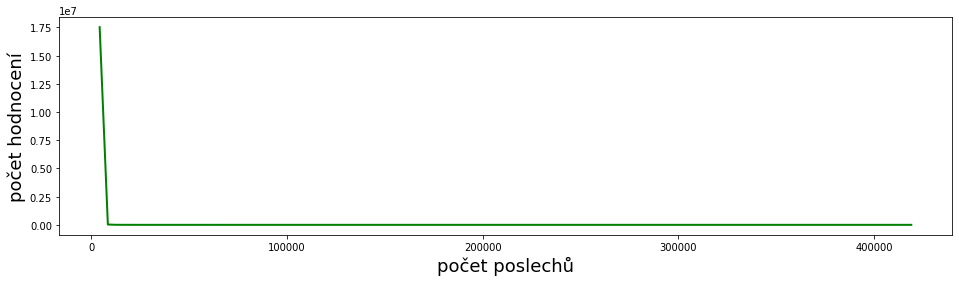

In [12]:
plot_hist(df)

In [13]:
from pyspark.sql import DataFrameStatFunctions as statFunc
quantiles = statFunc(df).approxQuantile("listenCount", [0.05, 0.95], 0.001)
quantiles

[6.0, 751.0]

In [14]:
dfFiltered = df.where(col("listenCount") > quantiles[0]).where(col("listenCount") < quantiles[1])
dfFiltered.count()                                                                                      

15697593

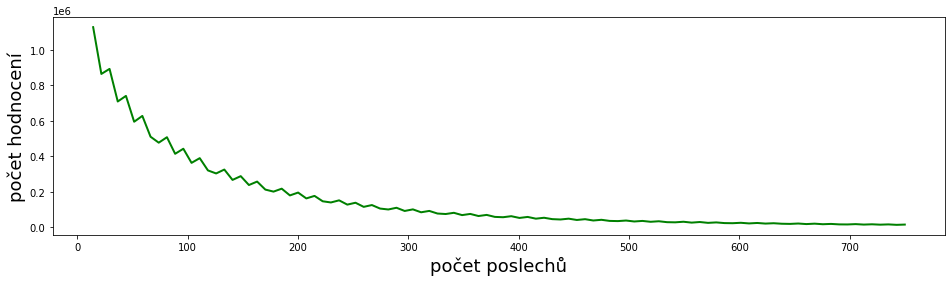

In [15]:
plot_hist(dfFiltered)

In [16]:
train, test = dfFiltered.randomSplit([0.7, 0.3])
train.write.mode("overwrite").save("/data/lastfm-dataset-360K/data-filtered-train.parquet")
test.write.mode("overwrite").save("/data/lastfm-dataset-360K/data-filtered-test.parquet")

In [17]:
dfFiltered.select(min("listenCount"), max("listenCount"), avg("listenCount")).show()
dfFiltered.select(variance("listenCount"), stddev("listenCount")).show()

+----------------+----------------+-----------------+
|min(listenCount)|max(listenCount)| avg(listenCount)|
+----------------+----------------+-----------------+
|             7.0|           750.0|149.6022127723658|
+----------------+----------------+-----------------+

+---------------------+------------------------+
|var_samp(listenCount)|stddev_samp(listenCount)|
+---------------------+------------------------+
|    23094.01524618548|      151.96715186574195|
+---------------------+------------------------+



In [33]:
mean = dfFiltered.select(avg("listenCount")).collect()[0][0]
stdDev = dfFiltered.select(stddev("listenCount")).collect()[0][0]

def zscore(listenCount, **model_kargs):
    return (listenCount - mean)/stdDev
    
dfStd = dfFiltered.withColumn("stdCount", zscore(dfFiltered.listenCount))

In [34]:
dfStd.show(10)
dfStd.write.mode("overwrite").save("/data/lastfm-dataset-360K/data-filtered-std.parquet")

+------+--------+-----------+--------------------+
|userId|artistId|listenCount|            stdCount|
+------+--------+-----------+--------------------+
|352323|   65907|       43.0| -0.7014819417458411|
| 68672|   65867|        8.0| -0.9317948716803401|
|108444|   65785|       31.0| -0.7804463748662408|
| 33557|   65741|      135.0|-0.09608795448944368|
|322776|   65741|      130.0|-0.12898980162294355|
| 12766|   64702|       55.0| -0.6225175086254414|
| 25985|   64702|       79.0|-0.46458864238464215|
| 66280|   64702|       75.0|  -0.490910120091442|
| 87701|   64702|       35.0| -0.7541248971594409|
|130003|   64702|       26.0| -0.8133482219997407|
+------+--------+-----------+--------------------+
only showing top 10 rows



In [3]:
dfStd = spark.read.load("/data/lastfm-dataset-360K/data-filtered-std.parquet")
dfStd.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- artistId: integer (nullable = true)
 |-- listenCount: float (nullable = true)
 |-- stdCount: double (nullable = true)



In [4]:
dfStd.select(min("stdCount")).show()
stdMin = dfStd.select(min("stdCount")).collect()[0][0]
stdMin

+-------------------+
|      min(stdCount)|
+-------------------+
|-0.9383752411070402|
+-------------------+



-0.9383752411070402

In [6]:
from pyspark.sql.functions import variance, stddev
dfStd.select(variance("stdCount"), stddev("stdCount")).show()

+------------------+---------------------+
|var_samp(stdCount)|stddev_samp(stdCount)|
+------------------+---------------------+
|1.0000000000000553|   1.0000000000000275|
+------------------+---------------------+



In [7]:
absStdMin = abs(stdMin)
print(absStdMin)

def shift(stdCount, **model_kargs):
    return stdCount + absStdMin

dfStdPos = dfStd.withColumn("stdCountPos", shift(dfStd.stdCount))
dfStdPos.show(10)
dfStdPos.write.mode("overwrite").save("/data/lastfm-dataset-360K/data-filtered-std-pos.parquet")

0.9383752411070402
+------+--------+-----------+--------------------+--------------------+
|userId|artistId|listenCount|            stdCount|         stdCountPos|
+------+--------+-----------+--------------------+--------------------+
|352323|   65907|       43.0| -0.7014819417458411| 0.23689329936119907|
| 68672|   65867|        8.0| -0.9317948716803401|0.006580369426700039|
|108444|   65785|       31.0| -0.7804463748662408| 0.15792886624079938|
| 33557|   65741|      135.0|-0.09608795448944368|  0.8422872866175966|
|322776|   65741|      130.0|-0.12898980162294355|  0.8093854394840967|
| 12766|   64702|       55.0| -0.6225175086254414| 0.31585773248159876|
| 25985|   64702|       79.0|-0.46458864238464215| 0.47378659872239803|
| 66280|   64702|       75.0|  -0.490910120091442| 0.44746512101559816|
| 87701|   64702|       35.0| -0.7541248971594409| 0.18425034394759932|
|130003|   64702|       26.0| -0.8133482219997407| 0.12502701910729952|
+------+--------+-----------+----------------

In [8]:
train, test = dfStdPos.randomSplit([0.7, 0.3])

train.write.mode("overwrite").save("/data/lastfm-dataset-360K/data-filtered-std-pos-train.parquet")
test.write.mode("overwrite").save("/data/lastfm-dataset-360K/data-filtered-std-pos-test.parquet")